In [1]:
%matplotlib inline

# plotting
import matplotlib as mpl
mpl.style.use('ggplot')
import matplotlib.pyplot as plt

# math and data manipulation
import numpy as np
import pandas as pd

# to handle paths
from pathlib import Path

# set random seeds 
from numpy.random import seed
from tensorflow import set_random_seed

# Tensorflow
from tensorflow import keras 
import tensorflow as tf

# progress bar
from tqdm import tqdm

from csef.utils import performance

RANDOM_SEED = 2018
seed(RANDOM_SEED)
set_random_seed(RANDOM_SEED)

/home/thuongdinh/.virtualenvs/mlcsef/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## Data Loading

In [2]:
data_path = Path('..', '..', 'data', 'raw')
consumption_train = pd.read_csv(data_path / 'consumption_train.csv', 
                                index_col=0, parse_dates=['timestamp'])
cold_start_test = pd.read_csv(data_path / 'cold_start_test.csv', 
                              index_col=0, parse_dates=['timestamp'])
submission_format = pd.read_csv(data_path / 'submission_format.csv',
                                index_col='pred_id',
                                parse_dates=['timestamp'])

## Features

In [3]:
from sklearn.preprocessing import MinMaxScaler

def create_lagged_features(df, lag=1):
    if not type(df) == pd.DataFrame:
        df = pd.DataFrame(df, columns=['consumption'])
    
    def _rename_lag(ser, j):
        ser.name = ser.name + f'_{j}'
        return ser
        
    # add a column lagged by `i` steps
    for i in range(1, lag + 1):
        df = df.join(df.consumption.shift(i).pipe(_rename_lag, i))

    df.dropna(inplace=True)
    return df

def prepare_training_data(consumption_series, lag):
    """ Converts a series of consumption data into a
        lagged, scaled sample.
    """
    # scale training data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    consumption_vals = scaler.fit_transform(consumption_series.values.reshape(-1, 1))
    
    # convert consumption series to lagged features
    consumption_lagged = create_lagged_features(consumption_vals, lag=lag)

    # X, y format taking the first column (original time series) to be the y
    X = consumption_lagged.drop('consumption', axis=1).values
    y = consumption_lagged.consumption.values
    
    # keras expects 3 dimensional X
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    return X, y, scaler

## Model fitting

In [4]:
# lag of 24 to simulate smallest cold start window. Our series
# will be converted to a num_timesteps x lag size matrix
lag = 24

# model parameters
num_neurons = 24
batch_size = 1  # this forces the lstm to step through each time-step one at a time
batch_input_shape=(batch_size, 1, lag)

# instantiate a sequential model
model = keras.Sequential()

# add LSTM layer - stateful MUST be true here in 
# order to learn the patterns within a series
model.add(keras.layers.LSTM(units=num_neurons, 
              batch_input_shape=batch_input_shape, 
              stateful=True))

# followed by a dense layer with a single output for regression
model.add(keras.layers.Dense(1))

# compile
model.compile(loss='mean_absolute_error', optimizer='adam')

In [ ]:
num_training_series = consumption_train.series_id.nunique()
num_passes_through_data = 3

total_timer = performance.Timer()

epoch_timers = []

for i in tqdm(range(num_passes_through_data), 
              total=num_passes_through_data, 
              desc='Learning Consumption Trends - Epoch'):
    
    epoch_timer = performance.Timer()
    
    # reset the LSTM state for training on each series
    for ser_id, ser_data in consumption_train.groupby('series_id'):

        # prepare the data
        X, y, scaler = prepare_training_data(ser_data.consumption, lag)

        # fit the model: note that we don't shuffle batches (it would ruin the sequence)
        # and that we reset states only after an entire X has been fit, instead of after
        # each (size 1) batch, as is the case when stateful=False
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    
    epoch_timers.append(epoch_timer)
    
    print(f'Finish an epoch in {epoch_timer.get_time()}')


In [10]:
epoch_timers

## Predict 

In [11]:
def generate_hourly_forecast(num_pred_hours, consumption, model, scaler, lag):
    """ Uses last hour's prediction to generate next for num_pred_hours, 
        initialized by most recent cold start prediction. Inverts scale of 
        predictions before return.
    """
    # allocate prediction frame
    preds_scaled = np.zeros(num_pred_hours)
    
    # initial X is last lag values from the cold start
    X = scaler.transform(consumption.values.reshape(-1, 1))[-lag:]
    
    # forecast
    for i in range(num_pred_hours):
        # predict scaled value for next time step
        yhat = model.predict(X.reshape(1, 1, lag), batch_size=1)[0][0]
        preds_scaled[i] = yhat
        
        # update X to be latest data plus prediction
        X = pd.Series(X.ravel()).shift(-1).fillna(yhat).values

    # revert scale back to original range
    hourly_preds = scaler.inverse_transform(preds_scaled.reshape(-1, 1)).ravel()
    return hourly_preds

In [12]:
my_submission = submission_format.copy()

In [13]:
pred_window_to_num_preds = {'hourly': 24, 'daily': 7, 'weekly': 2}
pred_window_to_num_pred_hours = {'hourly': 24, 'daily': 7 * 24, 'weekly': 2 * 7 * 24}

num_test_series = my_submission.series_id.nunique()

model.reset_states()

for ser_id, pred_df in tqdm(my_submission.groupby('series_id'), 
                            total=num_test_series, 
                            desc="Forecasting from Cold Start Data"):
        
    # get info about this series' prediction window
    pred_window = pred_df.prediction_window.unique()[0]
    num_preds = pred_window_to_num_preds[pred_window]
    num_pred_hours = pred_window_to_num_pred_hours[pred_window]
    
    # prepare cold start data
    series_data = cold_start_test[cold_start_test.series_id == ser_id].consumption
    cold_X, cold_y, scaler = prepare_training_data(series_data, lag)
    
    # fine tune our lstm model to this site using cold start data    
    model.fit(cold_X, cold_y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    
    # make hourly forecasts for duration of pred window
    preds = generate_hourly_forecast(num_pred_hours, series_data, model, scaler, lag)
    
    # reduce by taking sum over each sub window in pred window
    reduced_preds = [pred.sum() for pred in np.split(preds, num_preds)]
    
    # store result in submission DataFrame
    ser_id_mask = my_submission.series_id == ser_id
    my_submission.loc[ser_id_mask, 'consumption'] = reduced_preds

Forecasting from Cold Start Data: 100%|██████████| 625/625 [06:30<00:00,  1.54it/s]


In [14]:
my_submission[my_submission.prediction_window == 'hourly'].consumption.describe()

count    5.808000e+03
mean     1.663811e+05
std      6.177730e+05
min     -5.297255e+03
25%      1.593950e+04
50%      3.633444e+04
75%      9.121816e+04
max      5.180196e+06
Name: consumption, dtype: float64

In [15]:
my_submission[my_submission.prediction_window == 'daily'].consumption.describe()

count    1.337000e+03
mean     3.360650e+06
std      9.909110e+06
min      3.999166e+03
25%      3.908543e+05
50%      8.748407e+05
75%      2.667991e+06
max      1.167798e+08
Name: consumption, dtype: float64

In [16]:
my_submission[my_submission.prediction_window == 'weekly'].consumption.describe()

count    3.840000e+02
mean     2.339415e+07
std      6.386789e+07
min      1.902555e+04
25%      2.941646e+06
50%      7.358621e+06
75%      1.972825e+07
max      7.311404e+08
Name: consumption, dtype: float64

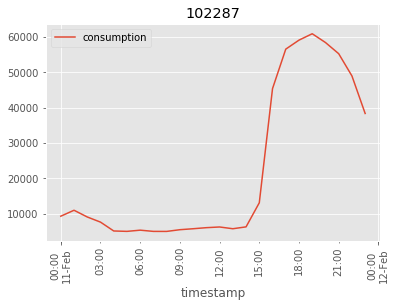

In [17]:
# plot samples
sample_ser = (my_submission[my_submission.prediction_window == 'hourly']
                           .series_id
                           .sample().values[0])

(my_submission[my_submission.series_id == sample_ser]
              .plot(x='timestamp',
                    y='consumption',
                    title=sample_ser,
                    rot=90))

In [18]:
my_submission.head(5)

,series_id,timestamp,temperature,consumption,prediction_window
pred_id,,,,,
0,102781,2013-03-03,19.931250,406801.400433,daily
1,102781,2013-03-04,20.034375,421880.141919,daily
2,102781,2013-03-05,19.189583,432310.590284,daily
3,102781,2013-03-06,18.397917,439185.464952,daily
4,102781,2013-03-07,20.762500,443644.634525,daily


In [19]:
save_path = Path('..', '..', 'data', 'submissions')
save_path.mkdir(exist_ok=True, parents=True)

my_submission.to_csv(save_path / "baseline-20181006.csv", index_label='pred_id')

The result is 0.4930 (rank 75/1176)